# TrainingMultiLabel

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [2]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report, multilabel_confusion_matrix

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14616244181801993105
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18200283115535621707
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'multi_label')
SAVED_DATASET_PATH = "datasets"
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

In [5]:
def display_cross_val_map_class(data_train, data_val, maps, title, legend1=['Train coffee', 'Val coffee'], legend2=['Train other', 'Val other'], xlim=[106,110], ylim=[10,16], figsize=(12,6)):
    fig, axes = plt.subplots(1,2,figsize=figsize)

    maps.plot(ax=axes[0],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)
    maps.plot(ax=axes[1],facecolor='Grey', edgecolor='k',alpha=0.5,linewidth=0.3)

    data_train[data_train['label_culture'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:green")
    data_val[data_val['label_culture'] == 0].plot(ax=axes[0], markersize=1,categorical=True, legend=True, c="tab:orange")
    
    data_train[data_train['label_culture'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:pink")
    data_val[data_val['label_culture'] == 1].plot(ax=axes[1], markersize=1,categorical=True, legend=True, c="tab:blue")

    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

    axes[0].set_xlabel("Latitude")
    axes[0].set_ylabel("Longitude")
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)

    axes[1].set_xlabel("Latitude")
    axes[1].set_ylabel("Longitude")

    legend = axes[0].legend(["Train coffee", "Val coffee"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]
    
    legend = axes[1].legend(["Train other", "Val other"])
    legend.legendHandles[0]._sizes = [30]
    legend.legendHandles[1]._sizes = [30]

    fig.suptitle(title)

In [6]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [7]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(2, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

In [8]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_multilabel_2'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

Fold 1 Number culture - train : 521
Fold 1 Number no-culture - train : 427
Fold 1 Number coffee - train : 239
Fold 1 Number other - train : 709
Fold 1 Number culture - val : 144
Fold 1 Number no-culture - val : 284
Fold 1 Number coffee - train : 39
Fold 1 Number other - train : 389
Training for fold 1
-----
Epoch 1/100
42/42 [==============================] - 16s 198ms/step - loss: 0.9977 - accuracy: 0.5434 - precision: 0.6332 - recall: 0.6362 - f1_score_keras: 0.6323 - val_loss: 0.9087 - val_accuracy: 0.7826 - val_precision: 0.8280 - val_recall: 0.9074 - val_f1_score_keras: 0.8655
Epoch 2/100
42/42 [==============================] - 6s 136ms/step - loss: 0.9217 - accuracy: 0.6231 - precision: 0.6521 - recall: 0.7821 - f1_score_keras: 0.7091 - val_loss: 0.8733 - val_accuracy: 0.7956 - val_precision: 0.9019 - val_recall: 0.8360 - val_f1_score_keras: 0.8674
Epoch 3/100
42/42 [==============================] - 6s 138ms/step - loss: 0.8652 - accuracy: 0.6810 - precision: 0.6778 - recall: 0

42/42 [==============================] - 6s 141ms/step - loss: 0.5385 - accuracy: 0.8295 - precision: 0.8507 - recall: 0.8779 - f1_score_keras: 0.8626 - val_loss: 0.6868 - val_accuracy: 0.7500 - val_precision: 0.9410 - val_recall: 0.7232 - val_f1_score_keras: 0.8174
Epoch 30/100
42/42 [==============================] - 6s 143ms/step - loss: 0.5288 - accuracy: 0.8339 - precision: 0.8442 - recall: 0.8827 - f1_score_keras: 0.8614 - val_loss: 0.7093 - val_accuracy: 0.7565 - val_precision: 0.9488 - val_recall: 0.7319 - val_f1_score_keras: 0.8250
Epoch 31/100
42/42 [==============================] - 6s 144ms/step - loss: 0.5276 - accuracy: 0.8364 - precision: 0.8372 - recall: 0.8911 - f1_score_keras: 0.8622 - val_loss: 0.7301 - val_accuracy: 0.7227 - val_precision: 0.9482 - val_recall: 0.6990 - val_f1_score_keras: 0.8034
Epoch 32/100
42/42 [==============================] - 6s 142ms/step - loss: 0.5176 - accuracy: 0.8346 - precision: 0.8344 - recall: 0.8990 - f1_score_keras: 0.8645 - val_los

42/42 [==============================] - 6s 143ms/step - loss: 0.4672 - accuracy: 0.8476 - precision: 0.8606 - recall: 0.8828 - f1_score_keras: 0.8698 - val_loss: 0.6728 - val_accuracy: 0.7148 - val_precision: 0.9465 - val_recall: 0.6750 - val_f1_score_keras: 0.7872
Epoch 59/100
42/42 [==============================] - 6s 139ms/step - loss: 0.4478 - accuracy: 0.8580 - precision: 0.8742 - recall: 0.8871 - f1_score_keras: 0.8795 - val_loss: 0.6440 - val_accuracy: 0.7266 - val_precision: 0.9748 - val_recall: 0.6816 - val_f1_score_keras: 0.8009
Epoch 60/100
42/42 [==============================] - 6s 141ms/step - loss: 0.4397 - accuracy: 0.8627 - precision: 0.8802 - recall: 0.8870 - f1_score_keras: 0.8824 - val_loss: 0.6511 - val_accuracy: 0.7331 - val_precision: 0.9596 - val_recall: 0.6954 - val_f1_score_keras: 0.8065
Epoch 61/100
42/42 [==============================] - 6s 143ms/step - loss: 0.4494 - accuracy: 0.8506 - precision: 0.8611 - recall: 0.8914 - f1_score_keras: 0.8756 - val_los

42/42 [==============================] - 6s 140ms/step - loss: 0.4191 - accuracy: 0.8703 - precision: 0.8845 - recall: 0.8966 - f1_score_keras: 0.8890 - val_loss: 0.6154 - val_accuracy: 0.7227 - val_precision: 0.9536 - val_recall: 0.6805 - val_f1_score_keras: 0.7941
Epoch 88/100
42/42 [==============================] - 6s 145ms/step - loss: 0.4235 - accuracy: 0.8661 - precision: 0.9002 - recall: 0.8767 - f1_score_keras: 0.8877 - val_loss: 0.6712 - val_accuracy: 0.6927 - val_precision: 0.9391 - val_recall: 0.6563 - val_f1_score_keras: 0.7725
Epoch 89/100
42/42 [==============================] - 6s 139ms/step - loss: 0.4065 - accuracy: 0.8699 - precision: 0.8912 - recall: 0.8889 - f1_score_keras: 0.8891 - val_loss: 0.6286 - val_accuracy: 0.7174 - val_precision: 0.9493 - val_recall: 0.6787 - val_f1_score_keras: 0.7905
Epoch 90/100
42/42 [==============================] - 6s 148ms/step - loss: 0.3949 - accuracy: 0.8729 - precision: 0.8884 - recall: 0.9033 - f1_score_keras: 0.8952 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 2 Number culture - train : 571
Fold 2 Number no-culture - train : 618
Fold 2 Number coffee - train : 261
Fold 2 Number other - train : 928
Fold 2 Number culture - val : 94
Fold 2 Number no-culture - val : 93
Fold 2 Number coffee - train : 17
Fold 2 Number other - train : 170
Training for fold 2
-----
Epoch 1/100
54/54 [==============================] - 15s 171ms/step - loss: 1.0658 - accuracy: 0.5084 - precision: 0.7234 - recall: 0.4594 - f1_score_keras: 0.4958 - val_loss: 0.9385 - val_accuracy: 0.8164 - val_precision: 0.8281 - val_recall: 0.9191 - val_f1_score_keras: 0.8712
Epoch 2/100
54/54 [==============================] - 7s 125ms/step - loss: 0.9572 - accuracy: 0.5814 - precision: 0.7006 - recall: 0.6150 - f1_score_keras: 0.6527 - val_loss: 0.8851 - val_accuracy: 0.8555 - val_precision: 0.8611 - val_recall: 0.9281 - val_f1_score_keras: 0.8936
Epoch 3/100
54/54 [==============================] - 7s 128ms/step - loss: 0.9005 - accuracy: 0.6509 - precision: 0.7249 - recall: 0.7

54/54 [==============================] - 7s 125ms/step - loss: 0.5613 - accuracy: 0.8110 - precision: 0.8352 - recall: 0.8840 - f1_score_keras: 0.8580 - val_loss: 0.5451 - val_accuracy: 0.8594 - val_precision: 0.8836 - val_recall: 0.9227 - val_f1_score_keras: 0.9029
Epoch 30/100
54/54 [==============================] - 7s 128ms/step - loss: 0.5518 - accuracy: 0.8126 - precision: 0.8295 - recall: 0.8941 - f1_score_keras: 0.8595 - val_loss: 0.5451 - val_accuracy: 0.8398 - val_precision: 0.8482 - val_recall: 0.9310 - val_f1_score_keras: 0.8878
Epoch 31/100
54/54 [==============================] - 7s 123ms/step - loss: 0.5394 - accuracy: 0.8201 - precision: 0.8452 - recall: 0.8912 - f1_score_keras: 0.8660 - val_loss: 0.5258 - val_accuracy: 0.8750 - val_precision: 0.9206 - val_recall: 0.9110 - val_f1_score_keras: 0.9159
Epoch 32/100
54/54 [==============================] - 7s 125ms/step - loss: 0.5483 - accuracy: 0.8190 - precision: 0.8405 - recall: 0.8894 - f1_score_keras: 0.8626 - val_los

54/54 [==============================] - 7s 127ms/step - loss: 0.4667 - accuracy: 0.8476 - precision: 0.8629 - recall: 0.9069 - f1_score_keras: 0.8832 - val_loss: 0.4939 - val_accuracy: 0.8477 - val_precision: 0.8454 - val_recall: 0.9480 - val_f1_score_keras: 0.8925
Epoch 59/100
54/54 [==============================] - 7s 124ms/step - loss: 0.4521 - accuracy: 0.8492 - precision: 0.8683 - recall: 0.9099 - f1_score_keras: 0.8881 - val_loss: 0.4601 - val_accuracy: 0.8594 - val_precision: 0.8718 - val_recall: 0.9392 - val_f1_score_keras: 0.9021
Epoch 60/100
54/54 [==============================] - 7s 123ms/step - loss: 0.4698 - accuracy: 0.8403 - precision: 0.8564 - recall: 0.9010 - f1_score_keras: 0.8776 - val_loss: 0.4389 - val_accuracy: 0.8867 - val_precision: 0.8923 - val_recall: 0.9560 - val_f1_score_keras: 0.9235
Epoch 61/100
54/54 [==============================] - 7s 128ms/step - loss: 0.4323 - accuracy: 0.8624 - precision: 0.8792 - recall: 0.9145 - f1_score_keras: 0.8949 - val_los

54/54 [==============================] - 7s 126ms/step - loss: 0.4300 - accuracy: 0.8493 - precision: 0.8691 - recall: 0.9058 - f1_score_keras: 0.8870 - val_loss: 0.4606 - val_accuracy: 0.8398 - val_precision: 0.8525 - val_recall: 0.9176 - val_f1_score_keras: 0.8836
Epoch 88/100
54/54 [==============================] - 6s 121ms/step - loss: 0.4124 - accuracy: 0.8655 - precision: 0.8745 - recall: 0.9280 - f1_score_keras: 0.8992 - val_loss: 0.4265 - val_accuracy: 0.8711 - val_precision: 0.8978 - val_recall: 0.9227 - val_f1_score_keras: 0.9101
Epoch 89/100
54/54 [==============================] - 7s 125ms/step - loss: 0.4131 - accuracy: 0.8619 - precision: 0.8785 - recall: 0.9144 - f1_score_keras: 0.8950 - val_loss: 0.4431 - val_accuracy: 0.8711 - val_precision: 0.8901 - val_recall: 0.9341 - val_f1_score_keras: 0.9115
Epoch 90/100
54/54 [==============================] - 7s 126ms/step - loss: 0.4234 - accuracy: 0.8626 - precision: 0.8766 - recall: 0.9112 - f1_score_keras: 0.8925 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 3 Number culture - train : 549
Fold 3 Number no-culture - train : 479
Fold 3 Number coffee - train : 200
Fold 3 Number other - train : 828
Fold 3 Number culture - val : 116
Fold 3 Number no-culture - val : 232
Fold 3 Number coffee - train : 78
Fold 3 Number other - train : 270
Training for fold 3
-----
Epoch 1/100
48/48 [==============================] - 15s 182ms/step - loss: 1.0094 - accuracy: 0.5899 - precision: 0.6788 - recall: 0.7044 - f1_score_keras: 0.6238 - val_loss: 0.8192 - val_accuracy: 0.7156 - val_precision: 0.7138 - val_recall: 0.9911 - val_f1_score_keras: 0.8295
Epoch 2/100
48/48 [==============================] - 6s 131ms/step - loss: 0.9210 - accuracy: 0.6332 - precision: 0.6900 - recall: 0.7696 - f1_score_keras: 0.7265 - val_loss: 0.7617 - val_accuracy: 0.7156 - val_precision: 0.7171 - val_recall: 0.9729 - val_f1_score_keras: 0.8243
Epoch 3/100
48/48 [==============================] - 6s 133ms/step - loss: 0.8720 - accuracy: 0.6851 - precision: 0.7245 - recall: 0

48/48 [==============================] - 6s 137ms/step - loss: 0.5689 - accuracy: 0.8199 - precision: 0.8287 - recall: 0.8902 - f1_score_keras: 0.8572 - val_loss: 0.5427 - val_accuracy: 0.7797 - val_precision: 0.7862 - val_recall: 0.9641 - val_f1_score_keras: 0.8660
Epoch 30/100
48/48 [==============================] - 6s 130ms/step - loss: 0.5627 - accuracy: 0.8216 - precision: 0.8451 - recall: 0.8827 - f1_score_keras: 0.8628 - val_loss: 0.5650 - val_accuracy: 0.7547 - val_precision: 0.7616 - val_recall: 0.9610 - val_f1_score_keras: 0.8488
Epoch 31/100
48/48 [==============================] - 6s 132ms/step - loss: 0.5415 - accuracy: 0.8316 - precision: 0.8443 - recall: 0.8976 - f1_score_keras: 0.8693 - val_loss: 0.6591 - val_accuracy: 0.7078 - val_precision: 0.7038 - val_recall: 0.9671 - val_f1_score_keras: 0.8142
Epoch 32/100
48/48 [==============================] - 6s 133ms/step - loss: 0.5463 - accuracy: 0.8286 - precision: 0.8373 - recall: 0.8955 - f1_score_keras: 0.8643 - val_los

48/48 [==============================] - 6s 133ms/step - loss: 0.4590 - accuracy: 0.8525 - precision: 0.8620 - recall: 0.9183 - f1_score_keras: 0.8882 - val_loss: 0.6291 - val_accuracy: 0.7484 - val_precision: 0.7550 - val_recall: 0.9723 - val_f1_score_keras: 0.8493
Epoch 59/100
48/48 [==============================] - 6s 132ms/step - loss: 0.4625 - accuracy: 0.8545 - precision: 0.8648 - recall: 0.9151 - f1_score_keras: 0.8886 - val_loss: 0.6280 - val_accuracy: 0.7250 - val_precision: 0.7313 - val_recall: 0.9761 - val_f1_score_keras: 0.8359
Epoch 60/100
48/48 [==============================] - 6s 130ms/step - loss: 0.4625 - accuracy: 0.8515 - precision: 0.8623 - recall: 0.9155 - f1_score_keras: 0.8869 - val_loss: 0.6558 - val_accuracy: 0.7281 - val_precision: 0.7288 - val_recall: 0.9755 - val_f1_score_keras: 0.8341
Epoch 61/100
48/48 [==============================] - 6s 131ms/step - loss: 0.4468 - accuracy: 0.8573 - precision: 0.8639 - recall: 0.9229 - f1_score_keras: 0.8910 - val_los

48/48 [==============================] - 6s 131ms/step - loss: 0.4160 - accuracy: 0.8656 - precision: 0.8755 - recall: 0.9204 - f1_score_keras: 0.8968 - val_loss: 0.7140 - val_accuracy: 0.6938 - val_precision: 0.7003 - val_recall: 0.9729 - val_f1_score_keras: 0.8138
Epoch 88/100
48/48 [==============================] - 6s 130ms/step - loss: 0.4285 - accuracy: 0.8596 - precision: 0.8685 - recall: 0.9137 - f1_score_keras: 0.8891 - val_loss: 0.7013 - val_accuracy: 0.7188 - val_precision: 0.7241 - val_recall: 0.9665 - val_f1_score_keras: 0.8274
Epoch 89/100
48/48 [==============================] - 6s 133ms/step - loss: 0.4138 - accuracy: 0.8654 - precision: 0.8674 - recall: 0.9256 - f1_score_keras: 0.8946 - val_loss: 0.7561 - val_accuracy: 0.7047 - val_precision: 0.7131 - val_recall: 0.9641 - val_f1_score_keras: 0.8191
Epoch 90/100
48/48 [==============================] - 6s 135ms/step - loss: 0.4159 - accuracy: 0.8718 - precision: 0.8754 - recall: 0.9304 - f1_score_keras: 0.9010 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 4 Number culture - train : 567
Fold 4 Number no-culture - train : 671
Fold 4 Number coffee - train : 273
Fold 4 Number other - train : 965
Fold 4 Number culture - val : 98
Fold 4 Number no-culture - val : 40
Fold 4 Number coffee - train : 5
Fold 4 Number other - train : 133
Training for fold 4
-----
Epoch 1/100
57/57 [==============================] - 16s 158ms/step - loss: 0.9670 - accuracy: 0.6150 - precision: 0.7144 - recall: 0.7307 - f1_score_keras: 0.6834 - val_loss: 0.9054 - val_accuracy: 0.6680 - val_precision: 0.6473 - val_recall: 1.0000 - val_f1_score_keras: 0.7854
Epoch 2/100
57/57 [==============================] - 7s 125ms/step - loss: 0.8868 - accuracy: 0.6740 - precision: 0.7298 - recall: 0.8247 - f1_score_keras: 0.7722 - val_loss: 0.8157 - val_accuracy: 0.7695 - val_precision: 0.7421 - val_recall: 0.9880 - val_f1_score_keras: 0.8476
Epoch 3/100
57/57 [==============================] - 7s 122ms/step - loss: 0.8391 - accuracy: 0.7169 - precision: 0.7446 - recall: 0.86

57/57 [==============================] - 7s 122ms/step - loss: 0.5107 - accuracy: 0.8365 - precision: 0.8514 - recall: 0.9192 - f1_score_keras: 0.8824 - val_loss: 0.5249 - val_accuracy: 0.9062 - val_precision: 0.9312 - val_recall: 0.9198 - val_f1_score_keras: 0.9255
Epoch 30/100
57/57 [==============================] - 7s 124ms/step - loss: 0.5224 - accuracy: 0.8269 - precision: 0.8339 - recall: 0.9174 - f1_score_keras: 0.8728 - val_loss: 0.5309 - val_accuracy: 0.8789 - val_precision: 0.9276 - val_recall: 0.8758 - val_f1_score_keras: 0.9011
Epoch 31/100
57/57 [==============================] - 7s 126ms/step - loss: 0.5149 - accuracy: 0.8288 - precision: 0.8412 - recall: 0.9120 - f1_score_keras: 0.8744 - val_loss: 0.5178 - val_accuracy: 0.8945 - val_precision: 0.9133 - val_recall: 0.9073 - val_f1_score_keras: 0.9105
Epoch 32/100
57/57 [==============================] - 7s 123ms/step - loss: 0.4960 - accuracy: 0.8466 - precision: 0.8565 - recall: 0.9271 - f1_score_keras: 0.8896 - val_los

57/57 [==============================] - 7s 124ms/step - loss: 0.4307 - accuracy: 0.8602 - precision: 0.8725 - recall: 0.9240 - f1_score_keras: 0.8965 - val_loss: 0.5090 - val_accuracy: 0.8164 - val_precision: 0.9466 - val_recall: 0.7561 - val_f1_score_keras: 0.8394
Epoch 59/100
57/57 [==============================] - 7s 121ms/step - loss: 0.4342 - accuracy: 0.8603 - precision: 0.8720 - recall: 0.9222 - f1_score_keras: 0.8950 - val_loss: 0.4741 - val_accuracy: 0.8203 - val_precision: 0.9323 - val_recall: 0.7702 - val_f1_score_keras: 0.8437
Epoch 60/100
57/57 [==============================] - 7s 125ms/step - loss: 0.4365 - accuracy: 0.8591 - precision: 0.8731 - recall: 0.9213 - f1_score_keras: 0.8958 - val_loss: 0.5360 - val_accuracy: 0.7969 - val_precision: 0.9200 - val_recall: 0.7325 - val_f1_score_keras: 0.8138
Epoch 61/100
57/57 [==============================] - 7s 122ms/step - loss: 0.4381 - accuracy: 0.8531 - precision: 0.8684 - recall: 0.9201 - f1_score_keras: 0.8922 - val_los

57/57 [==============================] - 7s 121ms/step - loss: 0.4112 - accuracy: 0.8587 - precision: 0.8745 - recall: 0.9170 - f1_score_keras: 0.8941 - val_loss: 0.5434 - val_accuracy: 0.7422 - val_precision: 0.8917 - val_recall: 0.6687 - val_f1_score_keras: 0.7644
Epoch 88/100
57/57 [==============================] - 7s 125ms/step - loss: 0.3974 - accuracy: 0.8655 - precision: 0.8806 - recall: 0.9196 - f1_score_keras: 0.8986 - val_loss: 0.5308 - val_accuracy: 0.7773 - val_precision: 0.9134 - val_recall: 0.7160 - val_f1_score_keras: 0.8028
Epoch 89/100
57/57 [==============================] - 7s 123ms/step - loss: 0.3992 - accuracy: 0.8685 - precision: 0.8813 - recall: 0.9284 - f1_score_keras: 0.9030 - val_loss: 0.5000 - val_accuracy: 0.7656 - val_precision: 0.9322 - val_recall: 0.6790 - val_f1_score_keras: 0.7859
Epoch 90/100
57/57 [==============================] - 7s 127ms/step - loss: 0.3952 - accuracy: 0.8699 - precision: 0.8855 - recall: 0.9221 - f1_score_keras: 0.9024 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 5 Number culture - train : 452
Fold 5 Number no-culture - train : 649
Fold 5 Number coffee - train : 139
Fold 5 Number other - train : 962
Fold 5 Number culture - val : 213
Fold 5 Number no-culture - val : 62
Fold 5 Number coffee - train : 139
Fold 5 Number other - train : 136
Training for fold 5
-----
Epoch 1/100
51/51 [==============================] - 15s 171ms/step - loss: 0.9789 - accuracy: 0.6091 - precision: 0.7878 - recall: 0.6237 - f1_score_keras: 0.6815 - val_loss: 0.9412 - val_accuracy: 0.6211 - val_precision: 0.4918 - val_recall: 0.9574 - val_f1_score_keras: 0.6479
Epoch 2/100
51/51 [==============================] - 6s 129ms/step - loss: 0.8834 - accuracy: 0.6854 - precision: 0.8000 - recall: 0.7687 - f1_score_keras: 0.7829 - val_loss: 0.9173 - val_accuracy: 0.6875 - val_precision: 0.5394 - val_recall: 0.9570 - val_f1_score_keras: 0.6884
Epoch 3/100
51/51 [==============================] - 6s 127ms/step - loss: 0.8163 - accuracy: 0.7465 - precision: 0.8165 - recall: 0

51/51 [==============================] - 6s 126ms/step - loss: 0.5111 - accuracy: 0.8556 - precision: 0.8770 - recall: 0.9331 - f1_score_keras: 0.9035 - val_loss: 0.8231 - val_accuracy: 0.6875 - val_precision: 0.5278 - val_recall: 0.9607 - val_f1_score_keras: 0.6812
Epoch 30/100
51/51 [==============================] - 6s 128ms/step - loss: 0.4866 - accuracy: 0.8669 - precision: 0.8862 - recall: 0.9395 - f1_score_keras: 0.9114 - val_loss: 0.8190 - val_accuracy: 0.6777 - val_precision: 0.5291 - val_recall: 0.9402 - val_f1_score_keras: 0.6759
Epoch 31/100
51/51 [==============================] - 7s 131ms/step - loss: 0.4900 - accuracy: 0.8645 - precision: 0.8781 - recall: 0.9453 - f1_score_keras: 0.9103 - val_loss: 0.7979 - val_accuracy: 0.6914 - val_precision: 0.5202 - val_recall: 0.9766 - val_f1_score_keras: 0.6784
Epoch 32/100
51/51 [==============================] - 6s 127ms/step - loss: 0.4945 - accuracy: 0.8621 - precision: 0.8785 - recall: 0.9369 - f1_score_keras: 0.9060 - val_los

51/51 [==============================] - 6s 126ms/step - loss: 0.3986 - accuracy: 0.8999 - precision: 0.9155 - recall: 0.9535 - f1_score_keras: 0.9328 - val_loss: 0.7528 - val_accuracy: 0.6797 - val_precision: 0.5182 - val_recall: 0.9716 - val_f1_score_keras: 0.6750
Epoch 59/100
51/51 [==============================] - 6s 127ms/step - loss: 0.3943 - accuracy: 0.8983 - precision: 0.9132 - recall: 0.9521 - f1_score_keras: 0.9315 - val_loss: 0.7523 - val_accuracy: 0.6836 - val_precision: 0.5329 - val_recall: 0.9674 - val_f1_score_keras: 0.6870
Epoch 60/100
51/51 [==============================] - 6s 129ms/step - loss: 0.3982 - accuracy: 0.8927 - precision: 0.9053 - recall: 0.9536 - f1_score_keras: 0.9284 - val_loss: 0.7429 - val_accuracy: 0.6758 - val_precision: 0.5198 - val_recall: 0.9553 - val_f1_score_keras: 0.6702
Epoch 61/100
51/51 [==============================] - 6s 127ms/step - loss: 0.3973 - accuracy: 0.8978 - precision: 0.9118 - recall: 0.9515 - f1_score_keras: 0.9308 - val_los

51/51 [==============================] - 6s 128ms/step - loss: 0.3516 - accuracy: 0.9136 - precision: 0.9267 - recall: 0.9584 - f1_score_keras: 0.9421 - val_loss: 0.7726 - val_accuracy: 0.6738 - val_precision: 0.5322 - val_recall: 0.9630 - val_f1_score_keras: 0.6858
Epoch 88/100
51/51 [==============================] - 6s 125ms/step - loss: 0.3630 - accuracy: 0.9058 - precision: 0.9175 - recall: 0.9566 - f1_score_keras: 0.9363 - val_loss: 0.7335 - val_accuracy: 0.6797 - val_precision: 0.5347 - val_recall: 0.9465 - val_f1_score_keras: 0.6813
Epoch 89/100
51/51 [==============================] - 6s 124ms/step - loss: 0.3700 - accuracy: 0.9014 - precision: 0.9139 - recall: 0.9548 - f1_score_keras: 0.9335 - val_loss: 0.7181 - val_accuracy: 0.6992 - val_precision: 0.5693 - val_recall: 0.9450 - val_f1_score_keras: 0.7097
Epoch 90/100
51/51 [==============================] - 6s 126ms/step - loss: 0.3550 - accuracy: 0.9087 - precision: 0.9177 - recall: 0.9613 - f1_score_keras: 0.9387 - val_los

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/romain.capocasa/romain_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


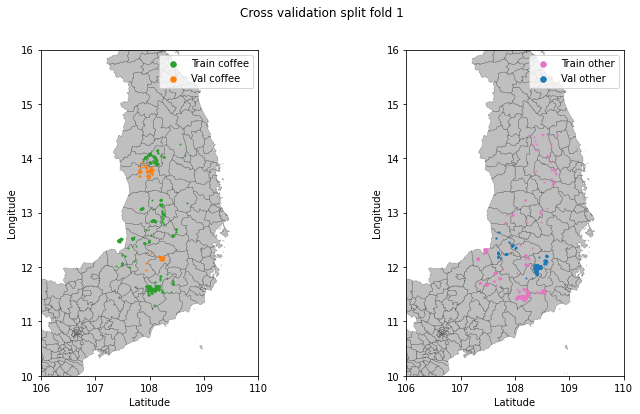

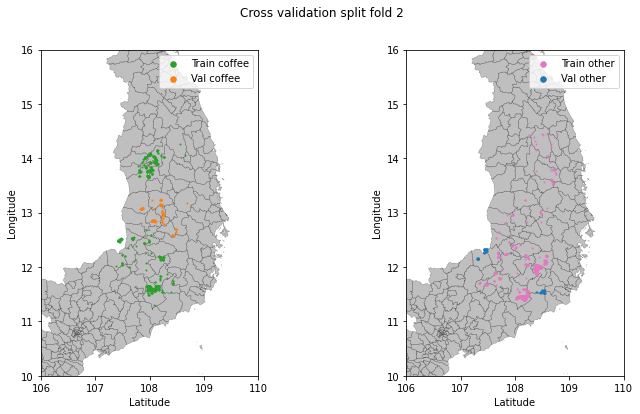

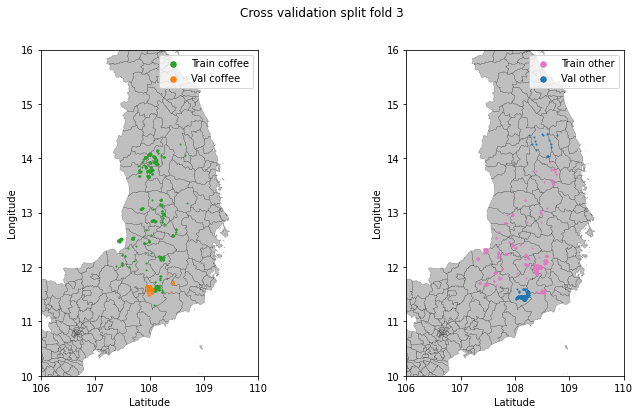

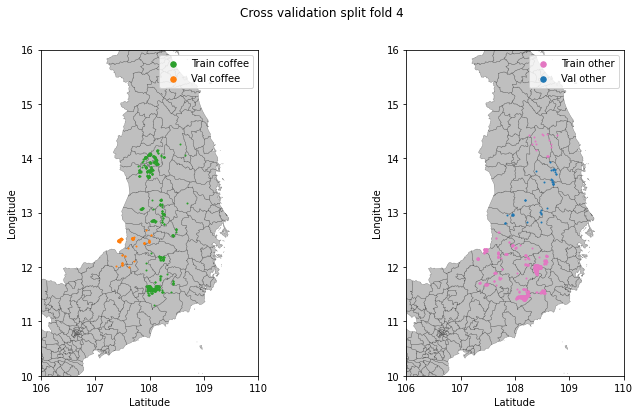

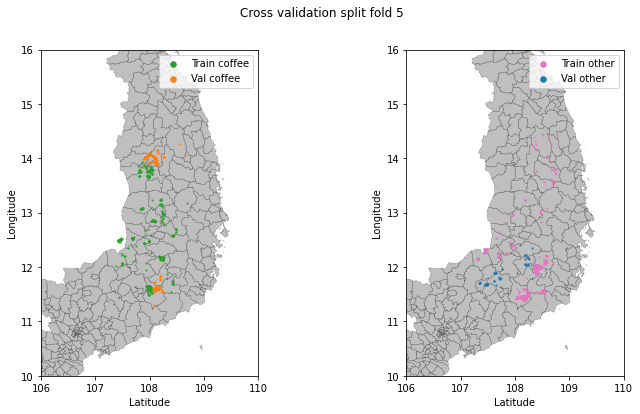

In [9]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_coffee_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_coffee_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold {i_fold+1}")
    
    print(f"Fold {i_fold+1} Number culture - train : {len(geo_train[geo_train['label_culture'] == 0])}")
    print(f"Fold {i_fold+1} Number no-culture - train : {len(geo_train[geo_train['label_culture'] == 1])}")
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label_coffee'] == 0])}")
    print(f"Fold {i_fold+1} Number other - train : {len(geo_train[geo_train['label_coffee'] == 1])}")

    print(f"Fold {i_fold+1} Number culture - val : {len(geo_val[geo_val['label_culture'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-culture - val : {len(geo_val[geo_val['label_culture'] == 1])}")
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_val[geo_val['label_coffee'] == 0])}")
    print(f"Fold {i_fold+1} Number other - train : {len(geo_val[geo_val['label_coffee'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train[['label_culture','label_coffee']].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val[['label_culture','label_coffee']].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)

    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE),
                        callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    validation_generator = generator(geo_val['path'].to_numpy(), 
                        geo_val[['label_culture','label_coffee']].to_numpy(), 
                        eurosat_params['mean'], 
                        eurosat_params['std'], 
                        batch_size=len(geo_val))
    
    Y_true = []
    Y_pred = []
    for i in range (0,1):
        X, Y = next(validation_generator)
        Y_pred.extend(np.where(model.predict(X) > 0.5, 1, 0))

        Y_true.extend(Y.tolist())

        Y_true = np.asarray(Y_true)
        Y_pred = np.asarray(Y_pred)

    cm = multilabel_confusion_matrix(Y_true, Y_pred)
    print(cm)
    print(classification_report(Y_true, Y_pred))

    print("\n")

    K.clear_session()

In [10]:
with open(os.path.join(SAVED_MODELS_PATH, 'multi_label', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [11]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.741015625
Stdev accuracy : 0.06707612498474215


Mean loss : 0.6181109309196472
Stdev loss : 0.11312719975785315


Mean precision : 0.7947420477867126
Stdev precision : 0.15454122040588908


Mean recall : 0.8415158152580261
Stdev recall : 0.15404442106690475


Mean F1-Score : 0.790131402015686
Stdev F1-Score : 0.07845697022987441


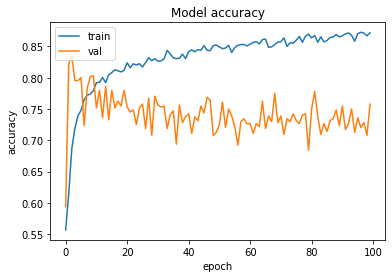

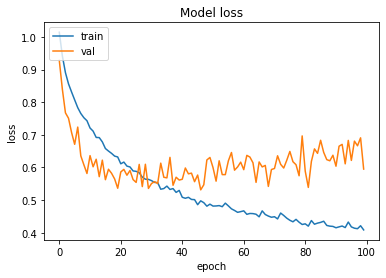

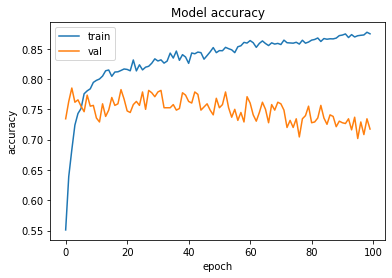

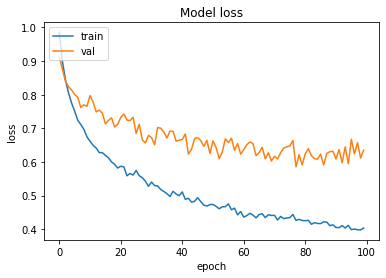

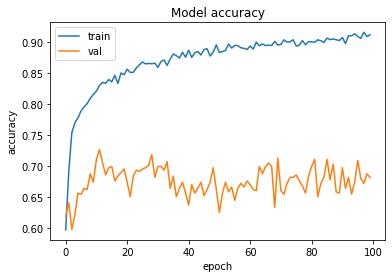

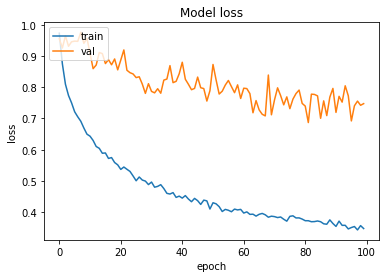

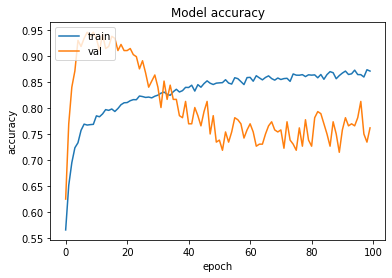

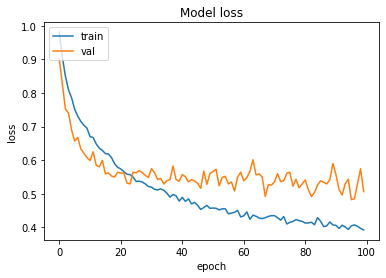

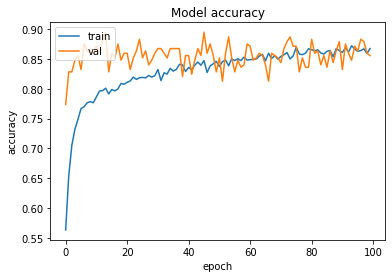

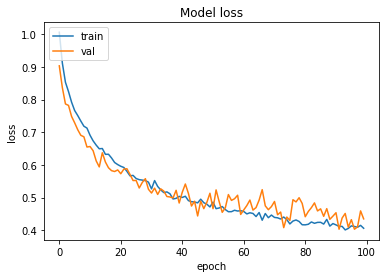

In [12]:
a = os.path.join(SAVED_MODELS_PATH, 'multi_label', 'final_spacv_10FOLD_multilabel_1')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()